# Задание 2.0

## Подключаем нужные библиотеки

In [61]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

import optuna
from optuna.visualization import plot_optimization_history

import shap

## Загружаем Dataset из первого задания

In [2]:
df = pd.read_csv("d:/loan_train.csv")
df = df.dropna()
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


Заменяем объекты на цифровые значения с помощью LabelEncoding

In [3]:
le = LabelEncoder()
df_encode= df.copy()
for i, f in enumerate(df.select_dtypes(include="object")):
    le.fit(df_encode[f])  
    df_encode[f] = le.fit_transform(df_encode[f])
df_encode.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,584900,0.0,15000000,360.0,1.0,2,1
1,1,1,1,0,0,458300,150800.0,12800000,360.0,1.0,0,0
2,1,1,0,0,1,300000,0.0,6600000,360.0,1.0,2,1
3,1,1,0,1,0,258300,235800.0,12000000,360.0,1.0,2,1
4,1,0,0,0,0,600000,0.0,14100000,360.0,1.0,2,1


In [4]:
X, y = df_encode.drop(columns='Status'), df_encode["Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.3)

## Задание 2.1. Построить более сложную модель с подбором гиперпараметров – 10б

В рамках данной точки необходимо использовать более сложную модель для решения задачи,  оптимизировать гиперпараметры и оценить ее качество.

Критерии оценки:

- Выбрана более сложная ML-модель - 1б.

- Произведен подбор гиперпараметров с использованием кросс-валидации - 4б.

- Выбранная модель обучена с лучшими подобранными значениями гиперпараметров - 4б.

- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - 1б.

### ОТВЕТ:
Рассмотрим простые модели(Logistic Regression, KNeighborsClassifier) и сложные ансамблевые и векторные(RandomForestClassifier, BaggingClassifier и SVC)
Для каждой модели было проведенно сначало обучение без подбора гиппер параметров и проедена оценка с помощью classification report позволяющий получить оценку точности, f1-score и др, а также accuracy_score.

Далее было проведенно сравнение Confusion Matrix до и после подбора гипер параметров с помощью sklearn GridSearchCV.

С  помощью Optuna был проведен подбор гиппер параметров и рассмотрена метрика для лучшего classifier с подобранными гиппер параметрами.

## Logistic Regression

In [5]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_sc = clf.predict(X_test)
print(classification_report(y_test, y_pred_sc))
print("Accuracy:",round(accuracy_score(y_test, y_pred_sc),3))

              precision    recall  f1-score   support

           0       0.93      0.32      0.47        41
           1       0.79      0.99      0.88       109

    accuracy                           0.81       150
   macro avg       0.86      0.65      0.68       150
weighted avg       0.83      0.81      0.77       150

Accuracy: 0.807


In [6]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression())
    ]
)


parameters = {
    'scaler__with_mean': [True, False],
    'clf__C': np.linspace(0.01, 1, 10),
    'clf__penalty': ['l2', 'none'],
    'clf__random_state': [2023],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=10,
)

In [7]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=5,
             param_grid={'clf__C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'clf__penalty': ['l2', 'none'],
                         'clf__random_state': [2023],
                         'scaler__with_mean': [True, False]},
             verbose=10)

In [8]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))
print("Accuracy:",round(accuracy_score(y_test, y_pred_optimized),3))

clf__C: 0.12
clf__penalty: l2
clf__random_state: 2023
scaler__with_mean: True
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       1.00      0.34      0.51        41
           1       0.80      1.00      0.89       109

    accuracy                           0.82       150
   macro avg       0.90      0.67      0.70       150
weighted avg       0.86      0.82      0.79       150

Accuracy: 0.82


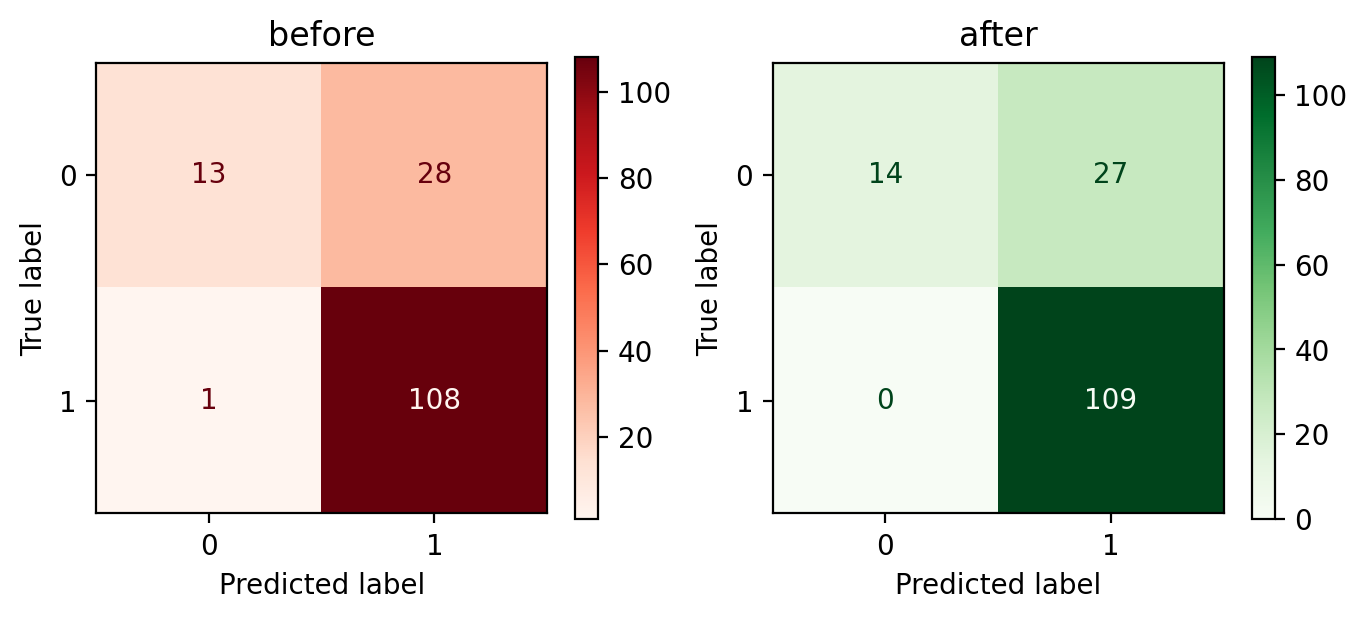

In [9]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_sc)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

## KNeighborsClassifier

In [10]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",round(accuracy_score(y_test, y_pred),3))

              precision    recall  f1-score   support

           0       0.26      0.22      0.24        41
           1       0.72      0.76      0.74       109

    accuracy                           0.61       150
   macro avg       0.49      0.49      0.49       150
weighted avg       0.59      0.61      0.60       150

Accuracy: 0.613


In [11]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('knc', KNeighborsClassifier())
    ]
)

parameters = {
    'scaler__with_mean': [True, False],
    'knc__weights': ['uniform', 'distance'],
    'knc__leaf_size': np.arange(1,100,1),
    'knc__n_neighbors': np.arange(1,10,1),
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

In [12]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3564 candidates, totalling 17820 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knc', KNeighborsClassifier())]),
             n_jobs=5,
             param_grid={'knc__leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'knc__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'knc__weights': ['uniform', 'distance'],
                         'scaler__with_mean': [True, False]},
             verbose=1)

In [13]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")


y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))
print("Accuracy:",round(accuracy_score(y_test, y_pred_optimized),3))

knc__leaf_size: 1
knc__n_neighbors: 7
knc__weights: uniform
scaler__with_mean: True
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.79      0.37      0.50        41
           1       0.80      0.96      0.88       109

    accuracy                           0.80       150
   macro avg       0.80      0.66      0.69       150
weighted avg       0.80      0.80      0.77       150

Accuracy: 0.8


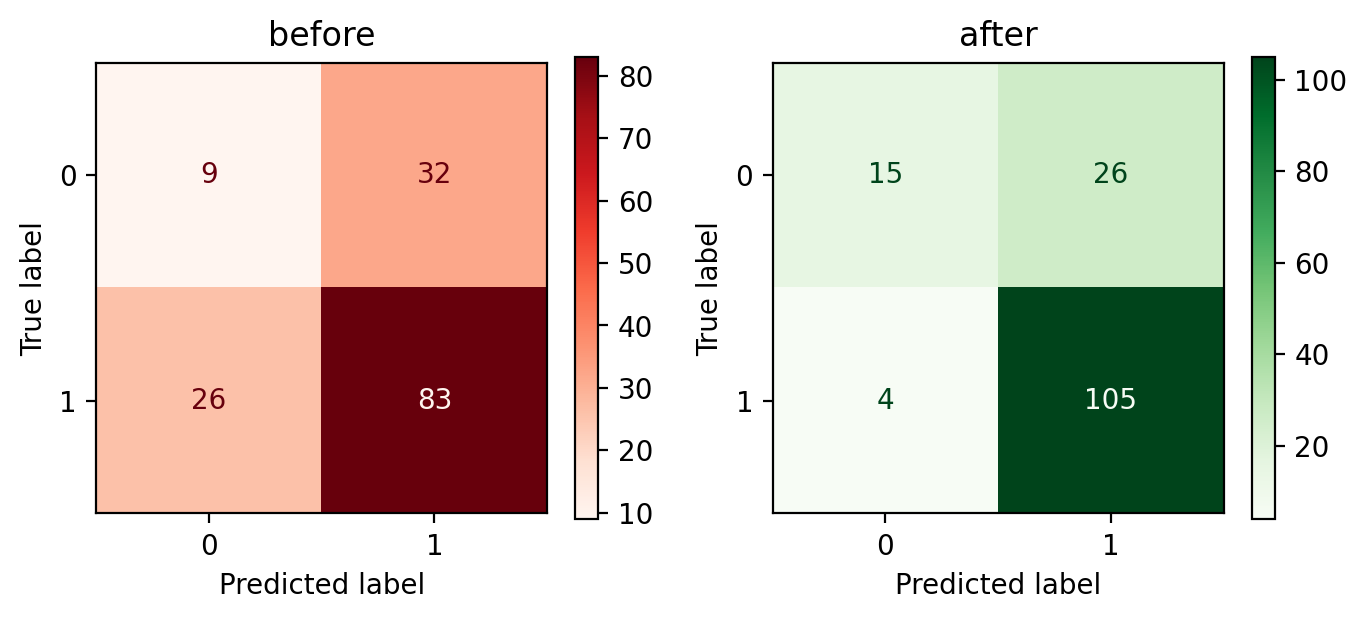

In [14]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

## RandomForestClassifier

In [15]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",round(accuracy_score(y_test, y_pred),3))

              precision    recall  f1-score   support

           0       0.64      0.34      0.44        41
           1       0.79      0.93      0.85       109

    accuracy                           0.77       150
   macro avg       0.71      0.63      0.65       150
weighted avg       0.75      0.77      0.74       150

Accuracy: 0.767


In [16]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('rfc', RandomForestClassifier())
    ]
)

parameters = {
    'scaler__with_mean': [True, False],
    # 'rfc__n_estimators': np.arange(50,150,5),
    'rfc__max_depth': np.arange(1,20,1),
    'rfc__criterion': ['gini', 'entropy', 'log_loss'],
    'rfc__class_weight': ['balanced', 'balanced_subsample', None]
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

In [17]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'rfc__class_weight': ['balanced', 'balanced_subsample',
                                               None],
                         'rfc__criterion': ['gini', 'entropy', 'log_loss'],
                         'rfc__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'scaler__with_mean': [True, False]},
             verbose=1)

In [18]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))
print("Accuracy:",round(accuracy_score(y_test, y_pred_optimized),3))

rfc__class_weight: None
rfc__criterion: gini
rfc__max_depth: 7
scaler__with_mean: True
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.88      0.34      0.49        41
           1       0.80      0.98      0.88       109

    accuracy                           0.81       150
   macro avg       0.84      0.66      0.69       150
weighted avg       0.82      0.81      0.77       150

Accuracy: 0.807


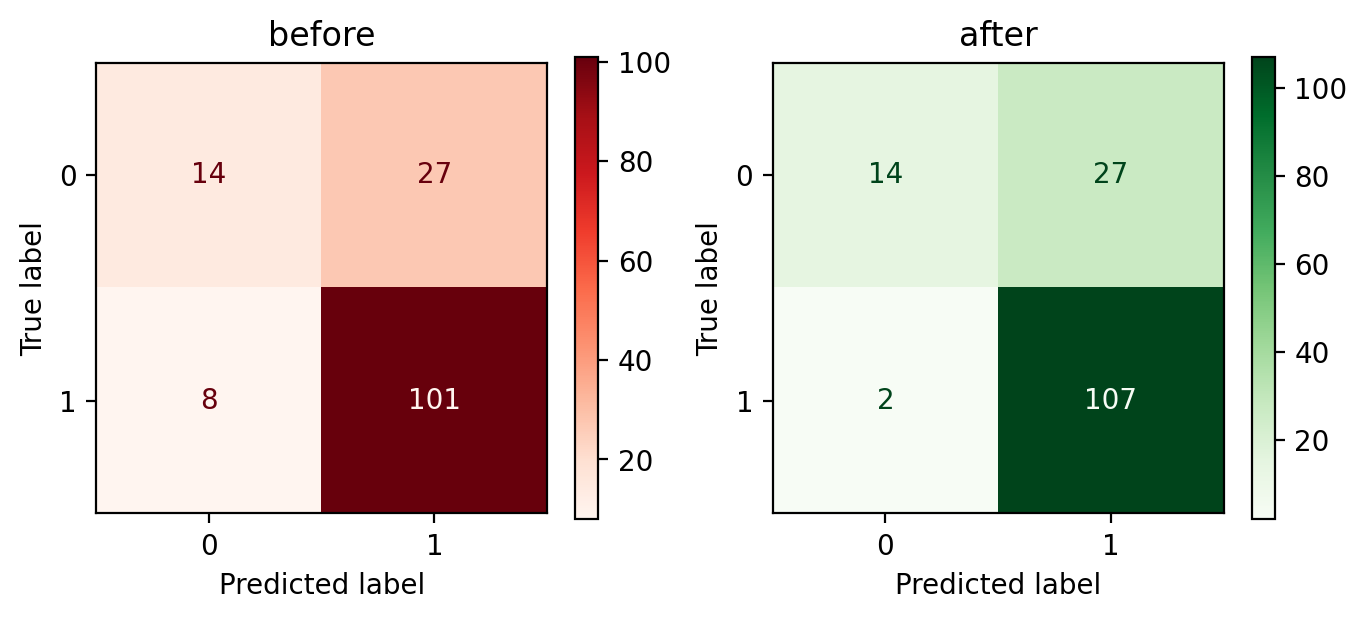

In [19]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

## SVC 

In [20]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",round(accuracy_score(y_test, y_pred),3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.73      1.00      0.84       109

    accuracy                           0.73       150
   macro avg       0.36      0.50      0.42       150
weighted avg       0.53      0.73      0.61       150

Accuracy: 0.727


In [21]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('svc', SVC())
    ]
)

parameters = {
    'scaler__with_mean': [True, False],
    'svc__C': 10**np.linspace(-10, 10, 21),
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

In [22]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=5,
             param_grid={'scaler__with_mean': [True, False],
                         'svc__C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])},
             verbose=1)

In [23]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))
print("Accuracy:",round(accuracy_score(y_test, y_pred_optimized),3))

scaler__with_mean: False
svc__C: 1.0
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.93      0.34      0.50        41
           1       0.80      0.99      0.89       109

    accuracy                           0.81       150
   macro avg       0.87      0.67      0.69       150
weighted avg       0.84      0.81      0.78       150

Accuracy: 0.813


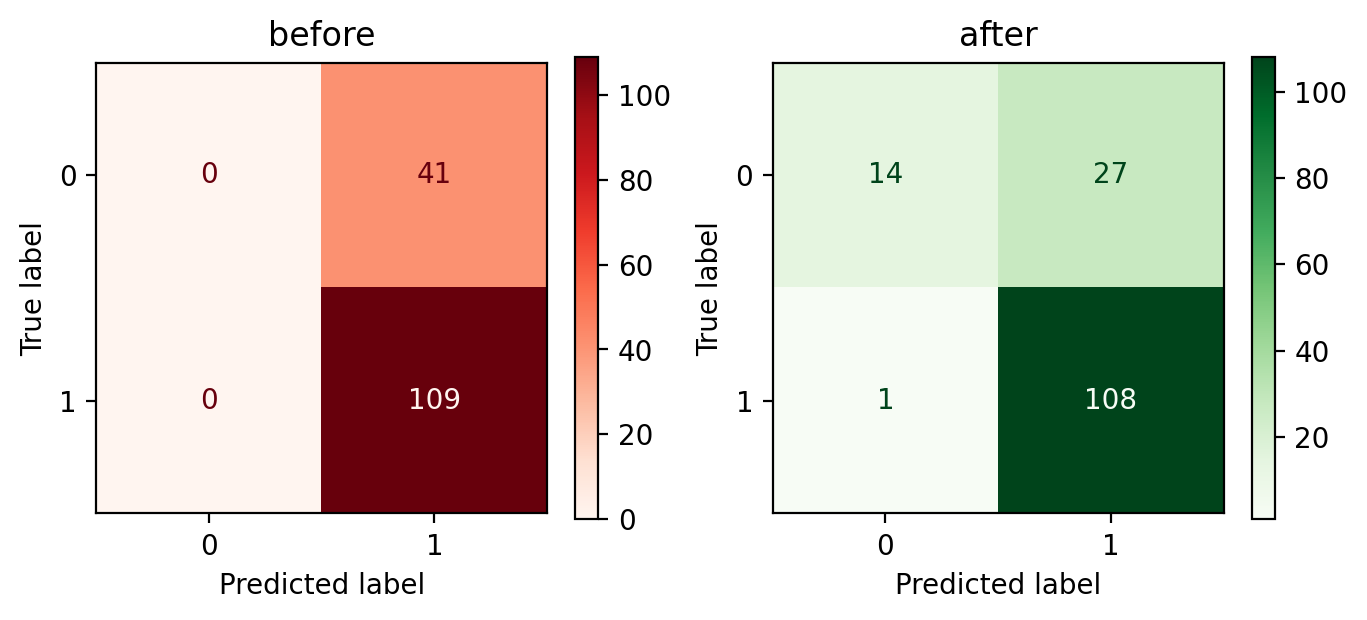

In [24]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

In [25]:
svc = BaggingClassifier()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",round(accuracy_score(y_test, y_pred),3))

              precision    recall  f1-score   support

           0       0.63      0.46      0.54        41
           1       0.82      0.90      0.86       109

    accuracy                           0.78       150
   macro avg       0.72      0.68      0.70       150
weighted avg       0.77      0.78      0.77       150

Accuracy: 0.78


In [26]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('bgc', BaggingClassifier())
    ]
)

parameters = {
    'scaler__with_mean': [True, False],
    'bgc__bootstrap': [True, False],
    'bgc__max_samples': np.arange(1, 20),
    'bgc__max_features': np.arange(1, 20),
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

In [27]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1444 candidates, totalling 7220 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('bgc', BaggingClassifier())]),
             n_jobs=5,
             param_grid={'bgc__bootstrap': [True, False],
                         'bgc__max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'bgc__max_samples': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'scaler__with_mean': [True, False]},
             verbose=1)

In [28]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))
print("Accuracy:",round(accuracy_score(y_test, y_pred_optimized),3))

bgc__bootstrap: False
bgc__max_features: 11
bgc__max_samples: 19
scaler__with_mean: True
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.89      0.41      0.57        41
           1       0.82      0.98      0.89       109

    accuracy                           0.83       150
   macro avg       0.86      0.70      0.73       150
weighted avg       0.84      0.83      0.80       150

Accuracy: 0.827


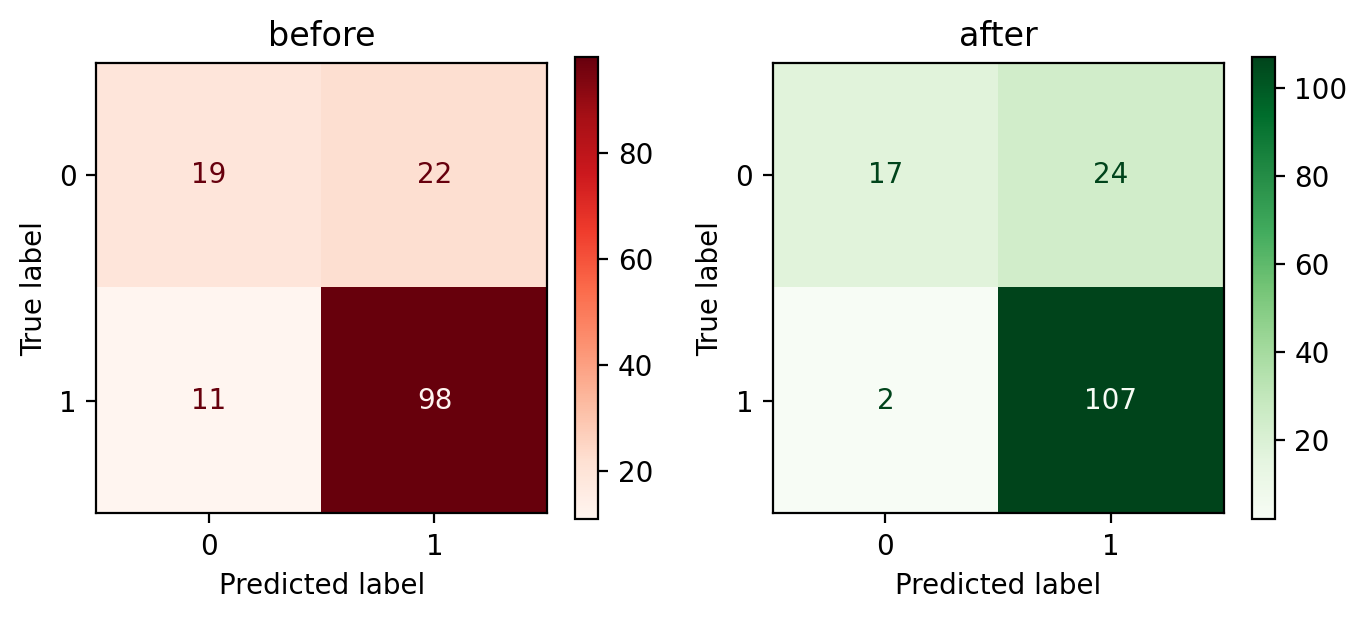

In [29]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

## Оптимизация гиперпараметров с помощью Optuna

In [30]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred_= rfc.predict(X_test)
print(classification_report(y_test, y_pred_))
print("Accuracy:",round(accuracy_score(y_test, y_pred),3))

              precision    recall  f1-score   support

           0       0.65      0.37      0.47        41
           1       0.80      0.93      0.86       109

    accuracy                           0.77       150
   macro avg       0.72      0.65      0.66       150
weighted avg       0.76      0.77      0.75       150

Accuracy: 0.78


In [31]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForestClassifier", "KNeighborsClassifier", "BaggingClassifier"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")

    elif classifier_name == "RandomForestClassifier":
        # n_estimators = trial.suggest_int('n_estimators', 1, 100)
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        class_weight =  trial.suggest_categorical('class_weight',['balanced', 'balanced_subsample', None])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 20)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, criterion=criterion, class_weight=class_weight)#, n_estimators=n_estimators)
        
    elif classifier_name == "KNeighborsClassifier":
        leaf_size = trial.suggest_int('leaf_size', 1, 100)
        n_neighbors = trial.suggest_int("n_neighbors", 1, 10)
        classifier_obj = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors)

    else:
        max_features = trial.suggest_int('max_features', 1, 10)
        max_samples = trial.suggest_int('max_samples', 1, 10)
        classifier_obj = BaggingClassifier(max_samples=max_samples, max_features=max_features, bootstrap=True)
    

    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-03-03 00:14:54,749] A new study created in memory with name: no-name-6e8204f2-fc3b-4c39-923c-326c09f91627
[I 2024-03-03 00:14:57,024] Trial 0 finished with value: 0.6646772767462423 and parameters: {'classifier': 'BaggingClassifier', 'max_features': 7, 'max_samples': 4}. Best is trial 0 with value: 0.6646772767462423.
[I 2024-03-03 00:14:58,072] Trial 1 finished with value: 0.6303664407112683 and parameters: {'classifier': 'KNeighborsClassifier', 'leaf_size': 71, 'n_neighbors': 7}. Best is trial 0 with value: 0.6646772767462423.
[I 2024-03-03 00:14:59,129] Trial 2 finished with value: 0.618896748207093 and parameters: {'classifier': 'KNeighborsClassifier', 'leaf_size': 27, 'n_neighbors': 5}. Best is trial 0 with value: 0.6646772767462423.
[I 2024-03-03 00:15:00,510] Trial 3 finished with value: 0.7907947735533942 and parameters: {'classifier': 'RandomForestClassifier', 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'rf_max_depth': 13}. Best is trial 3 with value:

In [33]:
plot_optimization_history(study)

In [34]:
best_params = study.best_params
print(best_params) 

{'classifier': 'RandomForestClassifier', 'criterion': 'gini', 'class_weight': 'balanced', 'rf_max_depth': 3}


In [35]:
rfc = RandomForestClassifier(max_depth=best_params['rf_max_depth'], criterion=best_params['criterion'], class_weight=best_params['class_weight'])#, n_estimators=best_params['n_estimators'])
rfc.fit(X_train,y_train)
y_pred_optuna= rfc.predict(X_test)
print(classification_report(y_test, y_pred_optuna))
print("Accuracy:",round(accuracy_score(y_test, y_pred_optuna),3))

              precision    recall  f1-score   support

           0       0.74      0.41      0.53        41
           1       0.81      0.94      0.87       109

    accuracy                           0.80       150
   macro avg       0.78      0.68      0.70       150
weighted avg       0.79      0.80      0.78       150

Accuracy: 0.8


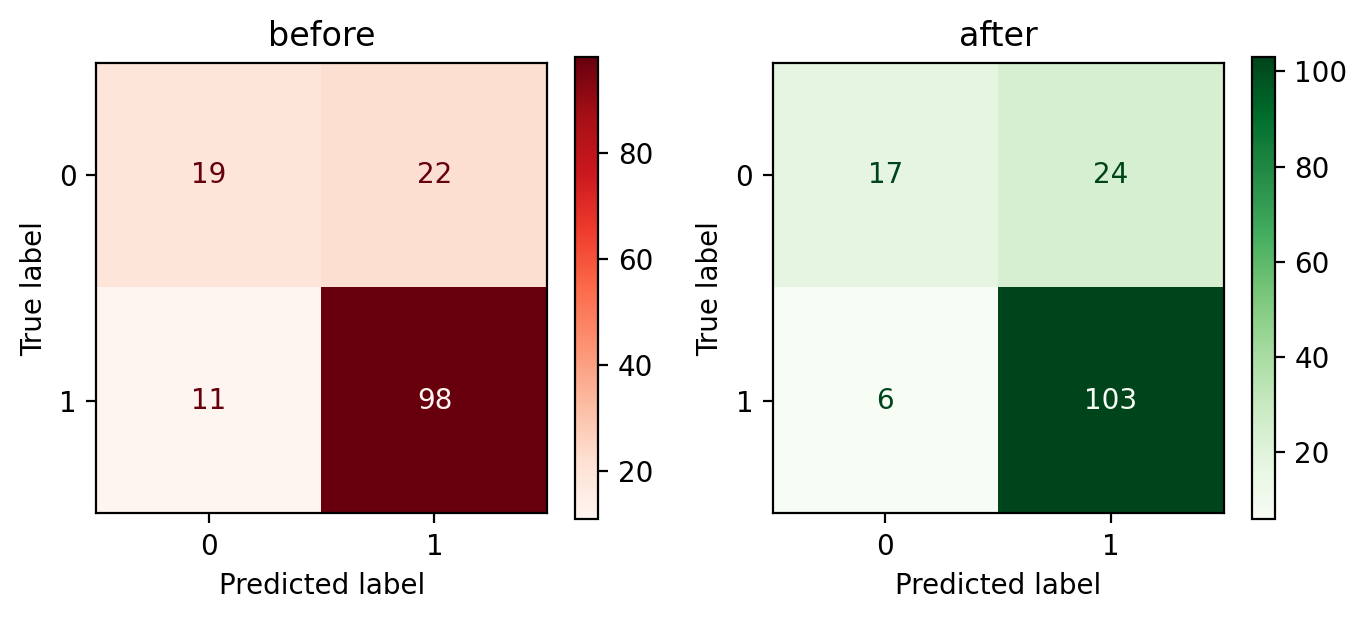

In [36]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optuna)).plot(cmap='Greens', ax=axes[1])

## Задание 2.2. Проинтерпретировать полученную модель – 10б

В рамках данного пункта необходимо проинтерпретировать модель, полученную в предыдущем пункте.

Критерии оценки:

- Получена интерпретация построенной модели, включая визуализации (коэффициенты/значения перестановок/ форма и тд) - 5 б. 

- Приведено экспертное мнение о полученной интерпретации (вы, как эксперт в предметной области, можете оценить адекватность признаков и решений, принимаемых моделью, и выразить свое мнение в 1-2 предложении) - 5 б.

In [43]:
scl = StandardScaler(with_mean=False)
X_train_scaled = pd.DataFrame(
    scl.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scl.transform(X_test),
    columns=X_test.columns
)

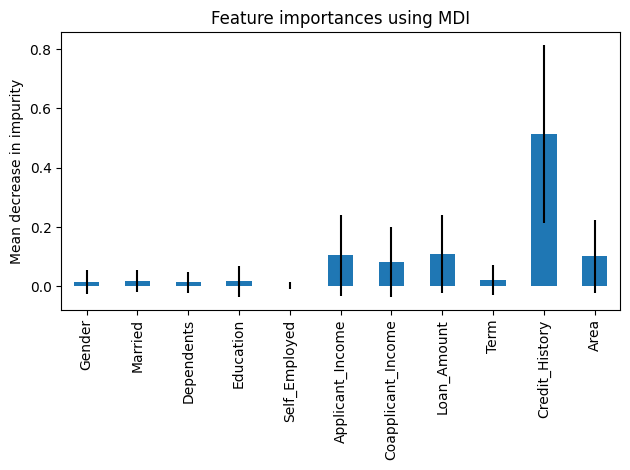

In [44]:
forest_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

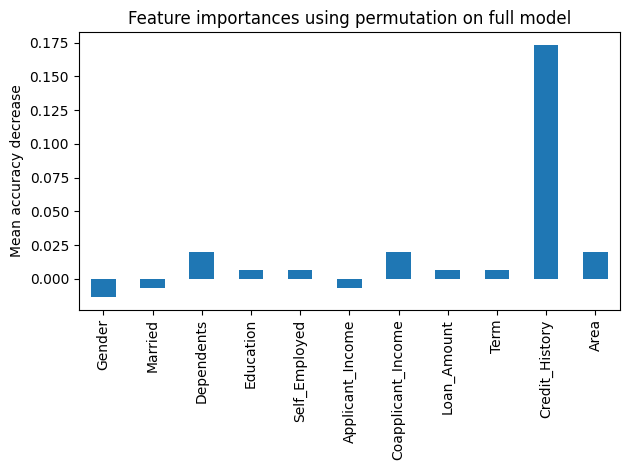

In [48]:
importances = permutation_importance(rfc, X_test, y_test, n_repeats=1, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [49]:
explainer = shap.TreeExplainer(rfc)
choosen_instance = X_test_scaled.loc[[10]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

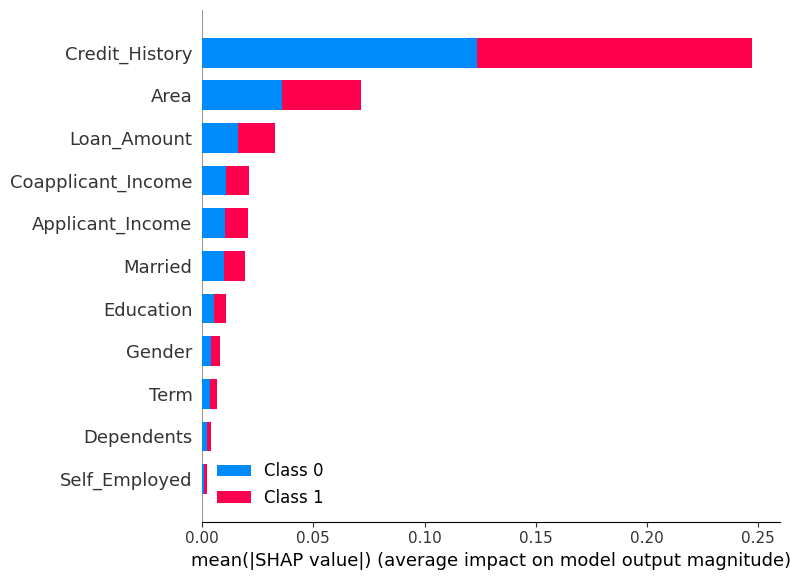

In [51]:
shap_values = explainer.shap_values(X_train.iloc[:])
shap.summary_plot(shap_values, X_train.iloc[:])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=2023, test_size=0.25)

In [54]:
clf_list = [RandomForestClassifier(random_state=2023), LogisticRegression()]

In [59]:
def plot_probability_curves(do_calibration=False):
  fig = plt.figure(figsize=(10, 10))
  gs = GridSpec(4, 2)
  colors = plt.cm.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  for i, clf in enumerate(clf_list):
    name = clf.__class__.__name__
    if do_calibration:
      clf = CalibratedClassifierCV(clf, cv="prefit", method='isotonic')
      clf.fit(X_valid, y_valid)
    else:
      clf.fit(X_train, y_train)

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

  plt.tight_layout()
  plt.show()

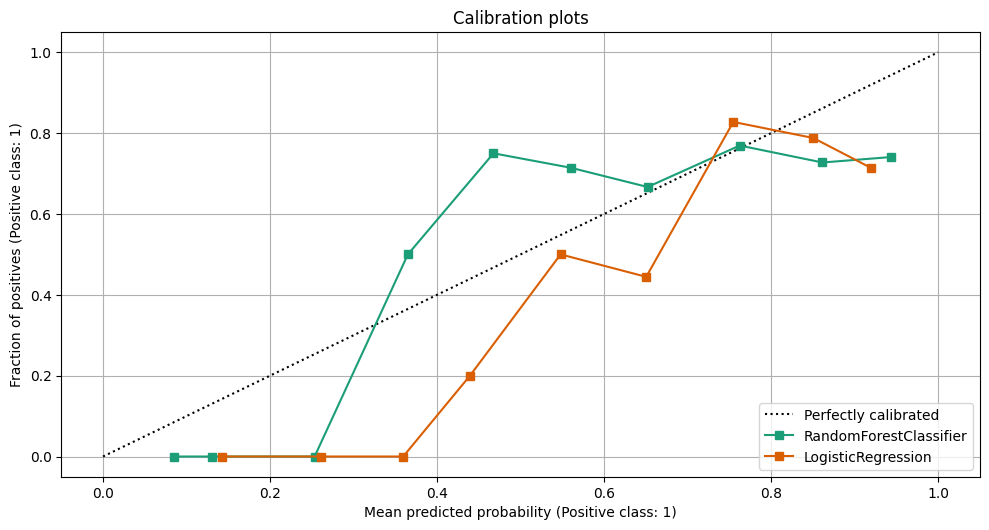

In [62]:
plot_probability_curves(do_calibration=False)

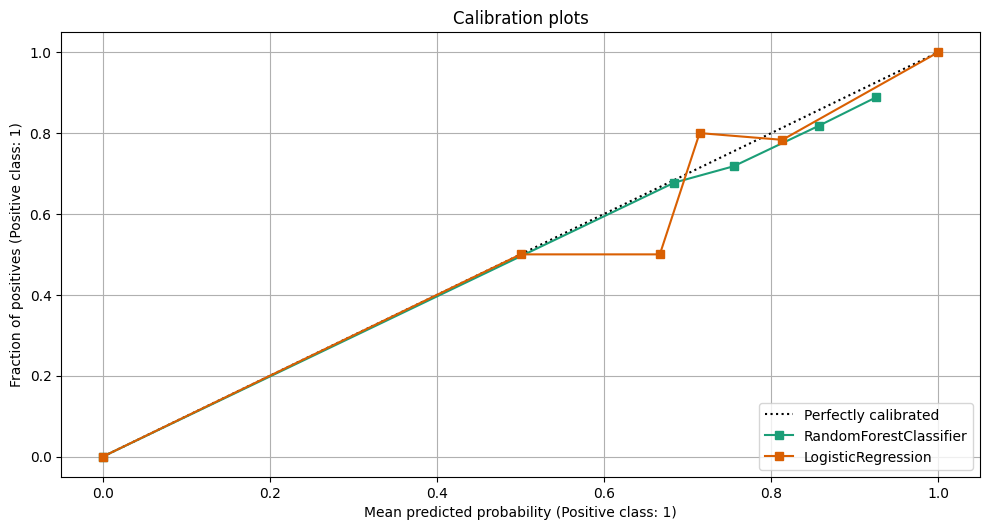

In [63]:
plot_probability_curves(do_calibration=True)

Выводы: 